In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn import linear_model

In [2]:
df_music = pd.read_csv('../music_data/billboard_top_100_1960_1969.csv')

In [3]:
df_music.describe()

,Rank,Year,SpotifyPlayCount
count,1000.000000,1000.000000,1.000000e+03
mean,50.547000,1964.501000,7.899737e+06
std,28.922799,2.875111,1.992258e+07
min,1.000000,1960.000000,1.554000e+03
25%,25.750000,1962.000000,2.437070e+05
50%,50.500000,1964.500000,8.641245e+05
75%,76.000000,1967.000000,4.963935e+06
max,100.000000,1969.000000,2.010574e+08


# 1 Visualization

## 1.1 Heat Map: Correlation

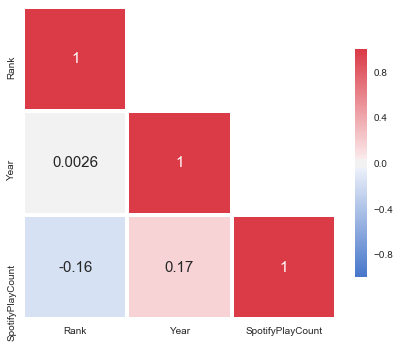

In [6]:
sns.set(style="white")
corr = df_music.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

## 1.2 Histogram: Play Count (Original)

In [54]:
df_playCount = df_music.SpotifyPlayCount

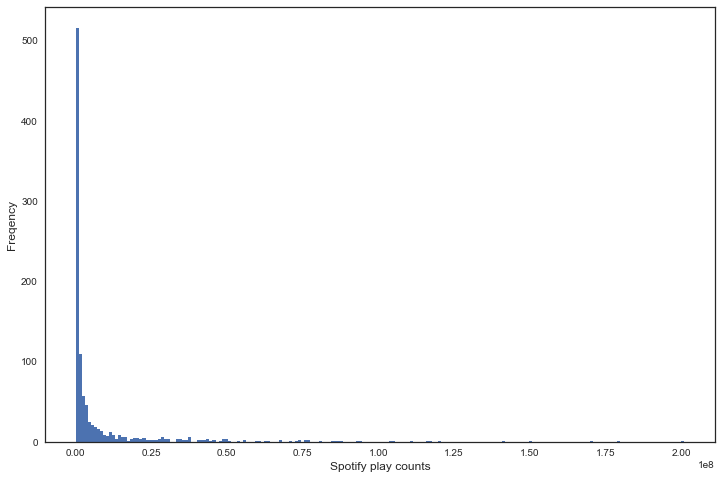

In [95]:
ax = df_playCount.plot.hist(bins=200, figsize=(12,8))
ax.set_xlabel("Spotify play counts", fontsize=12)
ax.set_ylabel("Freqency", fontsize=12)

In [72]:
df_playCount2 = df_music[df_music.SpotifyPlayCount < 1000000]

In [74]:
df_playCount2.shape

(513, 5)

The play count distribution is largely **skewed**. The biggest play count is over 200 million, while 513 out of 1000 songs have a play count lower than 1 million.

## 1.3 Histogram: Play Count (Logarithm)

In [85]:
df_playCount3 = np.log(df_music.SpotifyPlayCount)

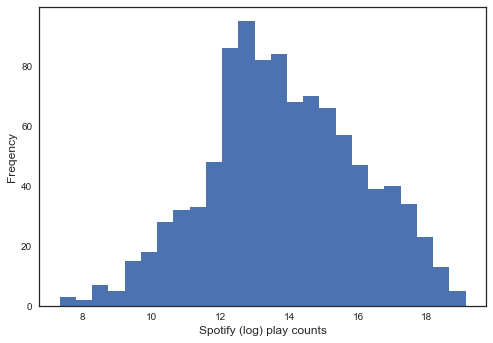

In [101]:
ax = df_playCount3.plot.hist(bins=25)
ax.set_xlabel("Spotify (log) play counts", fontsize=12)
ax.set_ylabel("Freqency", fontsize=12)

After logarithm, the distribution looks much like **bell shape**. It makes sense to change our original target to the log-target.

## 1.4 Heat Map: Correlation with Log Target

The following correlation heat map with **log** target is **better** than the correlation heat map with **original** target. Thus, doing logarithm help

In [4]:
df_music_clean = df_music.copy()
df_music_clean.SpotifyPlayCount = np.log(df_music_clean.SpotifyPlayCount)

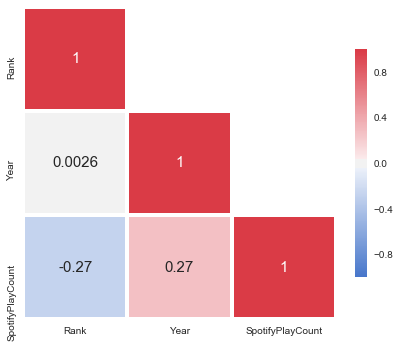

In [5]:
sns.set(style="white")
corr = df_music_clean.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.tril_indices_from(mask)] = False

# Set up the matplotlib figure
plt.subplots(figsize=(7, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(255, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True, annot_kws={"size":15}, linewidth=3, cbar_kws={"shrink": 0.6})

# 2 Baseline Model

## 2.1 Z-score the Features

In [99]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

## 2.2 Do the Linear Regression

# 3 Evaluation